### 📓 **Data Preprocessing Notebook – Real & Synthetic Dataset Support**

This notebook handles the initial preparation and validation of datasets used for binary fire classification. It supports both:

- 🔥 **Real-world dataset (D-Fire)**  
- 🧪 **Synthetic dataset (MSFFD by Yunnan University)**  

The notebook performs the following steps:

- Lets you select which dataset mode to use (`real` or `synthetic`)  
- Sets the appropriate file paths to images and YOLO-format labels stored in Google Drive  
- Imports the correct custom `Dataset` class depending on the selected mode  
- Applies torchvision transforms (e.g., resizing and tensor conversion)  
- Instantiates the dataset and verifies image-label pairing  
- Optionally previews sample images and binary labels to ensure correctness  

This preprocessing step ensures that the dataset pipeline is working correctly before training any classification model. Support for **mixed datasets** will be added in a future version of this notebook.


### 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is ready to run by:

- Mounting your Google Drive (where your token is stored)  
- Loading your GitHub token from Drive  
- Cloning the project repository into the Colab VM (fresh each time)  
- Navigating into the cloned repo  
- Setting Git credentials to enable committing changes if needed

> ⚠️ **Note**: This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔁 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 56 (delta 24), reused 37 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 244.13 KiB | 2.77 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/fire-detection-dissertation


### 🗂️ Step 1 – Define Dataset Mode and File Paths

In this step, we define which dataset to preprocess — either the **real-world D-Fire dataset** or the **synthetic MSFFD dataset** — and set the appropriate file paths for the images and corresponding YOLO label files stored in Google Drive.

These paths will be passed into the relevant custom `Dataset` class (e.g., `FireClassificationDataset_Real` or `FireClassificationDataset_Synthetic`) so it can read each image and assign a binary label (fire vs no fire).

Requirements:
- Image files must be in `.jpg` format
- Label files must have matching filenames with `.txt` extensions (YOLO format)
- The label logic differs between datasets, so the correct dataset class will be selected based on the chosen mode


In [5]:
# 🔧 Choose dataset mode: 'real' or 'synthetic'
dataset_mode = "synthetic"  # change to "real" if preprocessing D-Fire

# 📁 Define image and label directories based on selected dataset
if dataset_mode == "real":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/labels"
elif dataset_mode == "synthetic":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels"
else:
    raise ValueError("❌ Invalid dataset_mode. Choose either 'real' or 'synthetic'.")

print(f"✅ Mode: {dataset_mode}")
print(f"📂 Image directory: {image_dir}")
print(f"📂 Label directory: {label_dir}")


✅ Mode: synthetic
📂 Image directory: /content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images
📂 Label directory: /content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels


### 🔧 Step 2 – Import Appropriate Dataset Class and Define Image Transformations

In this step, we import the correct dataset class based on the selected mode:

- `FireClassificationDataset_Real` → for real-world D-Fire data  
- `FireClassificationDataset_Synthetic` → for synthetic MSFFD data  

Both classes are stored in the same helper file, but they handle label interpretation differently depending on the dataset.

We also define the image transformations using `torchvision.transforms`:
- Resize images to `224x224` (for ResNet-50)
- Convert images to PyTorch tensors
- Normalize pixel values to the `[0, 1]` range

These transforms are applied dynamically when each image is loaded.


In [3]:
from utils.fire_classification_dataset import FireClassificationDataset, FireClassificationSyntheticDataset
from torchvision import transforms

# Select the correct dataset class based on mode
if dataset_mode == "real":
    DatasetClass = FireClassificationDataset
elif dataset_mode == "synthetic":
    DatasetClass = FireClassificationSyntheticDataset
else:
    raise ValueError("Invalid dataset mode")

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required input size for ResNet-50
    transforms.ToTensor()           # Converts PIL Image to PyTorch Tensor in [0, 1]
])


### 📦 Step 3 – Create the Dataset Object and Inspect a Sample

We now instantiate the appropriate dataset class (`FireClassificationDataset` for real or `FireClassificationSyntheticDataset` for synthetic), using:

- The image and label directories specified earlier
- The preprocessing transform pipeline

This dataset object allows us to:
- Access image–label pairs using index notation (e.g., `dataset[0]`)
- Automatically apply transforms like resizing and tensor conversion
- Confirm that label values are assigned correctly (`0` or `1`)

We'll inspect a sample to verify:
- The image shape is `[3, 224, 224]` (RGB format)
- The label is a single PyTorch integer tensor (0 or 1)


In [7]:
# Create dataset object using the selected dataset class
dataset = DatasetClass(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=transform
)

# Load a sample image-label pair
sample_index = 3500  # Change this to inspect other samples
image, label = dataset[sample_index]

# Check shape and label
print("Image shape:", image.shape)  # Should be [3, 224, 224]
print("Label:", label.item())       # Should be 0 or 1


Image shape: torch.Size([3, 224, 224])
Label: 0


### 🖼️ Step 4 – Visualise a Sample Image and Its Binary Label

Now that the dataset is correctly loading image tensors and binary labels, we visually inspect a sample image to verify:

- The image has been read and transformed correctly
- The shape, orientation, and color channels look normal
- The binary label (`0` = no fire, `1` = fire) matches the image content

This visual confirmation helps validate the preprocessing pipeline before training. We'll use `matplotlib` to display the image and show the label in the title.


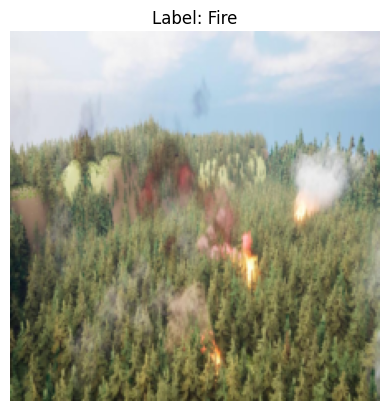

In [13]:
import matplotlib.pyplot as plt

# Select an index to preview
index = 2800  # Adjust this depending on dataset size
image, label = dataset[index]

# Convert image from tensor [C, H, W] to [H, W, C] for plotting
image_np = image.permute(1, 2, 0)

# Display the image and label
plt.imshow(image_np)
plt.title(f"Label: {'Fire' if label.item() == 1 else 'No Fire'}")
plt.axis('off')
plt.show()


In [15]:
# Move into the cloned GitHub repo (if not already there)
%cd /content/fire-detection-dissertation

# Stage the updated notebook
!git add notebooks/02_data_preprocessing.ipynb

# Commit the change with a clear message
!git commit -m "Update 02_data_preprocessing notebook: refactored for synthetic dataset compatibility"

# Push to GitHub
!git push


/content/fire-detection-dissertation
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date
